In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt

from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import gzip

import copy

import import_ipynb
from My_Functions import null_cols, rmse

importing Jupyter notebook from My_Functions.ipynb


In [2]:
acc_vred = pd.read_csv("acc_vred.csv.gz",
                                      compression='gzip',
                                      header=0,
                                      sep=',',
                                      quotechar='"')

acc_full = pd.read_csv("acc_2_train_final.csv.gz",
                                      compression='gzip',
                                      header=0,
                                      sep=',',
                                      quotechar='"')


target_2_train = pd.read_csv("target_2_train_final.csv.gz",
                                         compression='gzip',
                                         header=0,
                                         sep=',',
                                         quotechar='"')

In [3]:
# separate 'total_pymnt'

ttlpy_vred = copy.deepcopy(acc_full[['total_pymnt']])

In [4]:
state=0

# downsampled:
xtrain, xtest, ytrain, ytest = ms.train_test_split(acc_vred,
                                                   target_2_train,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()


# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Downsampled Data

In [5]:
xgb_clsfr = xgb.XGBClassifier()

train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

objective_ = ['binary:logistic']
evalmetric = ['auc']
uselabelencoder = [False]
treemethod = ['gpu_hist']
predictor_ = ['gpu_predictor']
njobs = [-1]
randomstate = [state]
booster_ = ['gbtree']

nestimators = [200]
minchildweight = [10]
maxdepth = [6]
learningrate = [0.05]
gamma_ = [1.5]
subsample_ = [0.8]
colsamplebytree = [0.7]


gparam_xgb = {'objective': objective_,
                 'eval_metric': evalmetric,
                 'use_label_encoder': uselabelencoder,
                 'tree_method': treemethod,
                 'predictor': predictor_,
                 'n_jobs': njobs,
                 'booster': booster_,
                 'n_estimators': nestimators,
                 'min_child_weight': minchildweight,
                 'max_depth': maxdepth,
                 'learning_rate': learningrate,
                 'gamma': gamma_,
                 'subsample': subsample_,
                 'colsample_bytree': colsamplebytree,
                 'random_state': randomstate}


gs_xgb = ms.GridSearchCV(xgb_clsfr, gparam_xgb, cv=n_folds, refit=True,
                          scoring='roc_auc', return_train_score=True, verbose=1)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))


# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
res_df = pd.DataFrame(list_results).T
res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
res_df = pd.concat([res_df, best_par_df], axis=1, sort=False)

# confusion matrix for train set
print('\n')
print('confusion matrix for train set')
print(confusion_matrix(ytrain, gs_xgb.predict(xtrain)))

# confusion matrix for test set
print('\n')
print('confusion matrix for test set')
print(confusion_matrix(ytest, gs_xgb.predict(xtest)))

res_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 7.72 s


confusion matrix for train set
[[69562 38148]
 [34389 73389]]


confusion matrix for test set
[[17100  9870]
 [ 8822 18080]]


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,booster,colsample_bytree,eval_metric,gamma,learning_rate,max_depth,min_child_weight,n_estimators,n_jobs,objective,predictor,random_state,subsample,tree_method,use_label_encoder
0,0.663383,0.653029,0.580187,0.589042,-0.008855,gbtree,0.7,auc,1.5,0.05,6,10,200,-1,binary:logistic,gpu_predictor,0,0.8,gpu_hist,False


In [6]:
gs_xgb.best_score_

0.7129892360296266

# Getting the indices of the rows for confusion matrix

https://stackoverflow.com/questions/50094999/how-to-return-an-array-of-false-positives-from-a-confusion-matrix-in-scikit-lear

In [7]:
ypred = gs_xgb.predict(xtest)

ypred = ypred.reshape(53872, 1)

In [8]:
# predicted as default and actually default
true_pos = np.logical_and(ytest == ypred, ypred == 1)

# predicted as default, but fully paid
false_pos = np.logical_and(ytest != ypred, ypred == 1)

# predicted as paid off and actually paid off
true_neg = np.logical_and(ytest == ypred, ypred == 0)

# predicted as paid off, but default
false_neg = np.logical_and(ytest != ypred, ypred == 0)

# getting indices of the above
true_pos_index = list(true_pos[true_pos['loan_status_binary']==True].index)

false_pos_index = list(false_pos[false_pos['loan_status_binary']==True].index)

true_neg_index = list(true_neg[true_neg['loan_status_binary']==True].index)

false_neg_index = list(false_neg[false_neg['loan_status_binary']==True].index)

In [9]:
false_neg_index

[225918,
 208257,
 265580,
 192904,
 153676,
 230512,
 220304,
 230302,
 214937,
 217829,
 242326,
 225759,
 137164,
 158284,
 205268,
 199424,
 137257,
 142642,
 200383,
 199062,
 172796,
 219032,
 223488,
 200394,
 260081,
 209633,
 228498,
 218396,
 216678,
 175476,
 145686,
 148553,
 146791,
 247803,
 196234,
 216113,
 147681,
 135099,
 252343,
 144692,
 206524,
 189067,
 157820,
 237525,
 203242,
 171286,
 144352,
 236370,
 231490,
 142749,
 238937,
 238413,
 239622,
 254780,
 248565,
 177577,
 220174,
 266105,
 148651,
 181158,
 201773,
 238407,
 201731,
 183871,
 145528,
 189831,
 141664,
 228811,
 180219,
 197668,
 268639,
 256293,
 218678,
 169463,
 246664,
 213974,
 230628,
 147990,
 189556,
 168389,
 230559,
 220866,
 253364,
 169551,
 141013,
 245986,
 218151,
 221257,
 139802,
 155106,
 170281,
 197635,
 144704,
 262652,
 259914,
 197652,
 267157,
 203382,
 178165,
 225213,
 166476,
 261173,
 171962,
 190196,
 228598,
 221474,
 168303,
 205402,
 176094,
 232738,
 171431,
 

In [10]:
# getting the sums of the total payments by the indices of the confusion matrix

sum_true_pos = np.sum(ttlpy_vred.iloc[true_pos_index][['total_pymnt']]).astype(int)[0]

sum_false_pos = np.sum(ttlpy_vred.iloc[false_pos_index][['total_pymnt']]).astype(int)[0]

sum_true_neg = np.sum(ttlpy_vred.iloc[true_neg_index][['total_pymnt']]).astype(int)[0]

sum_false_neg = np.sum(ttlpy_vred.iloc[false_neg_index][['total_pymnt']]).astype(int)[0]

In [11]:
sum_false_pos

162302534

In [12]:
sum_false_neg

64547399

In [13]:
sum_false_pos - sum_false_neg

97755135

In [14]:
# analyze the grades and interest rates of the false negatives

In [15]:
acc_false_neg = acc_vred.iloc[false_neg_index]

acc_false_neg[['outcome']] = 1

acc_false_neg

<ipython-input-15-05ad673c4c59>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_false_neg[['outcome']] = 1
C:\Users\tdcho\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,annual_inc,fico_score,term,loan_amnt,home_ownership,int_rate,all_util,dti,outcome
225918,0.027275,0.403397,0.0,0.253165,1.000000,0.421729,0.549133,0.01449,1
208257,0.004728,0.212314,0.0,0.240506,0.000000,0.337617,0.000000,0.01761,1
265580,0.005455,0.297240,0.0,0.164557,0.000000,0.114097,0.306358,0.01208,1
192904,0.012274,0.360934,0.0,0.253165,0.666667,0.201713,0.427746,0.01396,1
153676,0.009546,0.509554,1.0,0.508228,0.666667,0.182243,0.000000,0.02303,1
...,...,...,...,...,...,...,...,...,...
148388,0.024547,0.403397,0.0,0.367089,0.666667,0.000389,0.000000,0.01872,1
224929,0.009092,0.445860,0.0,0.367089,1.000000,0.260125,0.000000,0.01005,1
218695,0.007273,0.212314,0.0,0.206962,0.666667,0.401090,0.000000,0.00531,1
175450,0.007092,0.806794,0.0,0.594937,0.666667,0.079439,0.323699,0.02789,1


In [16]:
acc_false_pos = acc_vred.iloc[false_pos_index]

acc_false_pos[['outcome']] = 0

acc_false_pos

<ipython-input-16-3160ef065f5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_false_pos[['outcome']] = 0
C:\Users\tdcho\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,annual_inc,fico_score,term,loan_amnt,home_ownership,int_rate,all_util,dti,outcome
2276,0.001818,0.360934,0.0,0.215190,0.000000,0.401090,0.000000,0.03805,0
43909,0.010183,0.233546,0.0,0.746835,0.666667,0.727414,0.473988,0.02108,0
82267,0.005455,0.360934,1.0,0.582278,0.000000,0.503894,0.000000,0.03048,0
57291,0.007273,0.339703,1.0,0.822785,0.666667,0.325545,0.416185,0.02284,0
185,0.029184,0.360934,0.0,0.746835,0.000000,0.396417,0.578035,0.01042,0
...,...,...,...,...,...,...,...,...,...
5289,0.003819,0.530786,1.0,0.311392,0.666667,0.299065,0.000000,0.02549,0
51554,0.002728,0.212314,0.0,0.229114,0.666667,0.503505,0.000000,0.03412,0
126259,0.005000,0.403397,1.0,0.696203,0.666667,0.379283,0.352601,0.03508,0
91912,0.012546,0.318471,1.0,0.594937,0.000000,0.591121,0.000000,0.01539,0


In [17]:
col_names = list(acc_false_neg.columns)

acc_false = pd.DataFrame(np.concatenate((acc_false_neg, acc_false_pos)), columns=col_names)

acc_false

,annual_inc,fico_score,term,loan_amnt,home_ownership,int_rate,all_util,dti,outcome
0,0.027275,0.403397,0.0,0.253165,1.000000,0.421729,0.549133,0.01449,1.0
1,0.004728,0.212314,0.0,0.240506,0.000000,0.337617,0.000000,0.01761,1.0
2,0.005455,0.297240,0.0,0.164557,0.000000,0.114097,0.306358,0.01208,1.0
3,0.012274,0.360934,0.0,0.253165,0.666667,0.201713,0.427746,0.01396,1.0
4,0.009546,0.509554,1.0,0.508228,0.666667,0.182243,0.000000,0.02303,1.0
...,...,...,...,...,...,...,...,...,...
18687,0.003819,0.530786,1.0,0.311392,0.666667,0.299065,0.000000,0.02549,0.0
18688,0.002728,0.212314,0.0,0.229114,0.666667,0.503505,0.000000,0.03412,0.0
18689,0.005000,0.403397,1.0,0.696203,0.666667,0.379283,0.352601,0.03508,0.0
18690,0.012546,0.318471,1.0,0.594937,0.000000,0.591121,0.000000,0.01539,0.0


## Annual Income

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

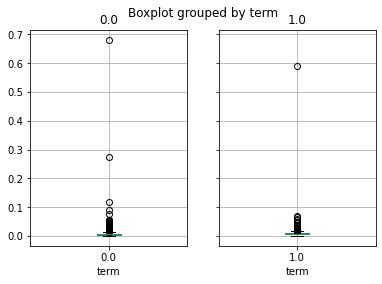

In [18]:
# false neg

acc_false_neg.groupby('term')[['term','annual_inc']].boxplot(by='term', column='annual_inc')

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

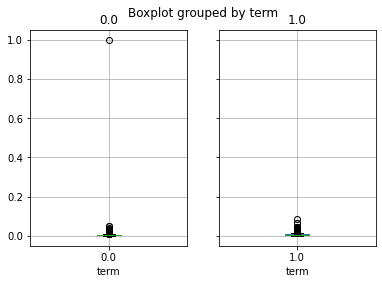

In [19]:
# false pos

acc_false_pos.groupby('term')[['term','annual_inc']].boxplot(by='term', column='annual_inc')

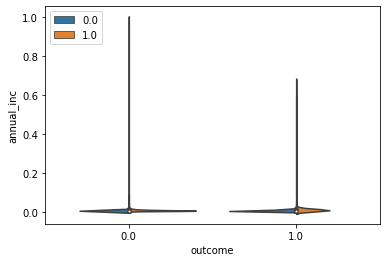

In [20]:
import seaborn as sns

# by outcome

fig, ax = plt.subplots()
ax = sns.violinplot(x='outcome', y='annual_inc', hue='term', data=acc_false, split=True)

ax.legend(loc=2)

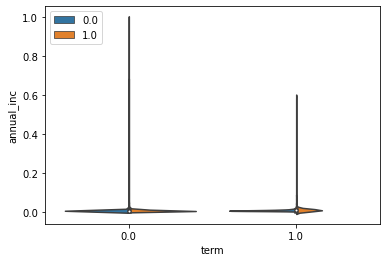

In [21]:
# by term

fig, ax = plt.subplots()
ax = sns.violinplot(x='term', y='annual_inc', hue='outcome', data=acc_false, split=True)

ax.legend(loc=2)

## Loan Amount

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

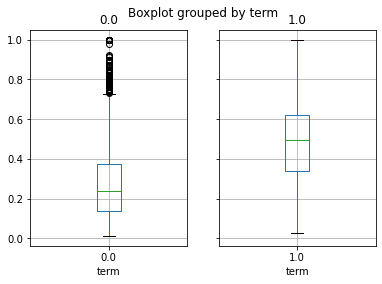

In [22]:
acc_false_neg.groupby('term')[['term','loan_amnt']].boxplot(by='term', column='loan_amnt')

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

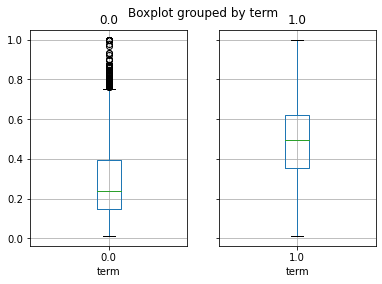

In [23]:
# false pos

acc_false_pos.groupby('term')[['term','loan_amnt']].boxplot(by='term', column='loan_amnt')

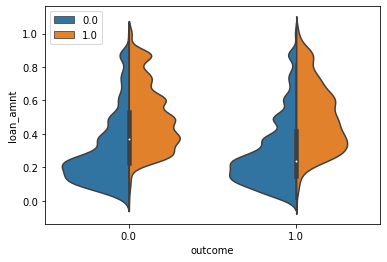

In [24]:
# by outcome

fig, ax = plt.subplots()
ax = sns.violinplot(x='outcome', y='loan_amnt', hue='term', data=acc_false, split=True)

ax.legend(loc=2)

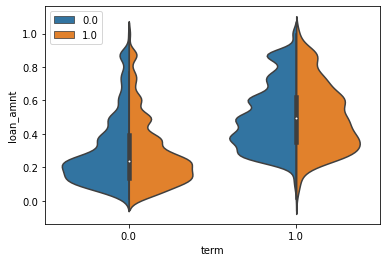

In [25]:
# by term

fig, ax = plt.subplots()
ax = sns.violinplot(x='term', y='loan_amnt', hue='outcome', data=acc_false, split=True)

ax.legend(loc=2)

## Home Ownership

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

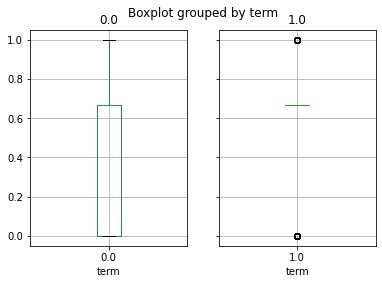

In [26]:
acc_false_neg.groupby('term')[['term','home_ownership']].boxplot(by='term', column='home_ownership')

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

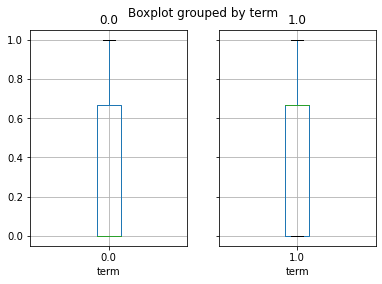

In [27]:
# false pos

acc_false_pos.groupby('term')[['term','home_ownership']].boxplot(by='term', column='home_ownership')

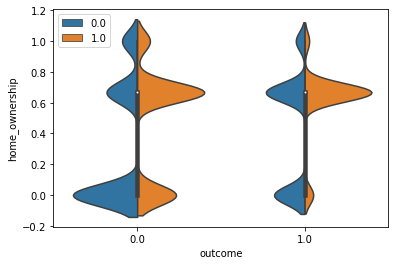

In [28]:
# by outcome

fig, ax = plt.subplots()
ax = sns.violinplot(x='outcome', y='home_ownership', hue='term', data=acc_false, split=True)

ax.legend(loc=2)

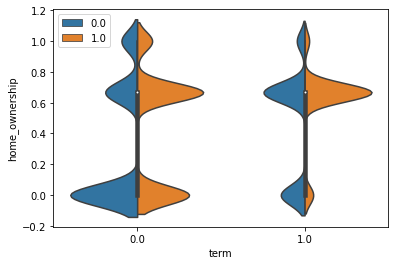

In [29]:
# by term

fig, ax = plt.subplots()
ax = sns.violinplot(x='term', y='home_ownership', hue='outcome', data=acc_false, split=True)

ax.legend(loc=2)

## Interest Rate

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

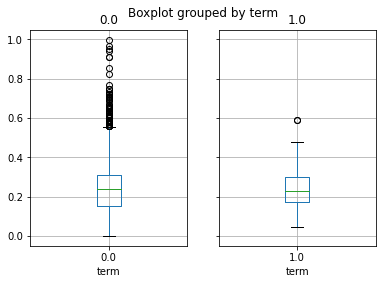

In [30]:
acc_false_neg.groupby('term')[['term','int_rate']].boxplot(by='term', column='int_rate')

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

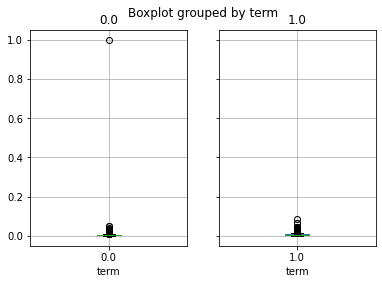

In [31]:
# false pos

acc_false_pos.groupby('term')[['term','annual_inc']].boxplot(by='term', column='annual_inc')

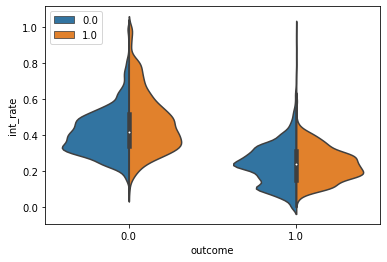

In [32]:
# by outcome

fig, ax = plt.subplots()
ax = sns.violinplot(x='outcome', y='int_rate', hue='term', data=acc_false, split=True)

ax.legend(loc=2)

# 60 month term more likely to default with lower interest rate
# 36 month term more likely to default with higher interest rate

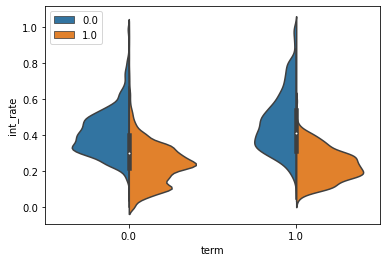

In [33]:
# by term

fig, ax = plt.subplots()
ax = sns.violinplot(x='term', y='int_rate', hue='outcome', data=acc_false, split=True)

ax.legend(loc=2)

## All Util

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

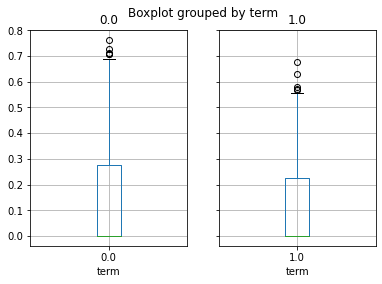

In [34]:
acc_false_neg.groupby('term')[['term','all_util']].boxplot(by='term', column='all_util')

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

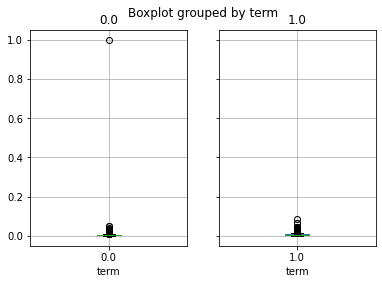

In [35]:
# false pos

acc_false_pos.groupby('term')[['term','all_util']].boxplot(by='term', column='annual_inc')

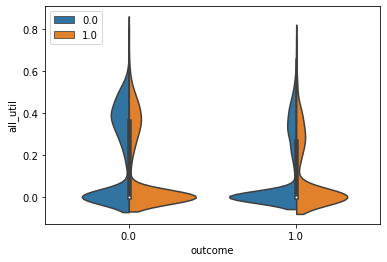

In [36]:
# by outcome

fig, ax = plt.subplots()
ax = sns.violinplot(x='outcome', y='all_util', hue='term', data=acc_false, split=True)

ax.legend(loc=2)

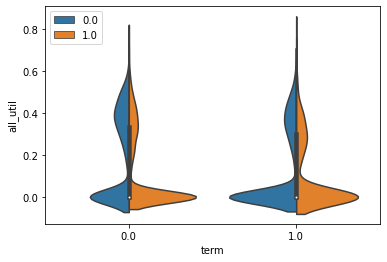

In [37]:
# by term

fig, ax = plt.subplots()
ax = sns.violinplot(x='term', y='all_util', hue='outcome', data=acc_false, split=True)

ax.legend(loc=2)

# Debt to Income

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

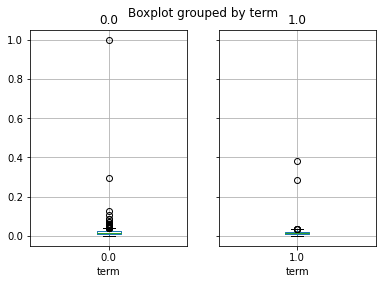

In [38]:
acc_false_neg.groupby('term')[['term','dti']].boxplot(by='term', column='dti')

0.0         AxesSubplot(0.1,0.15;0.363636x0.75)
1.0    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

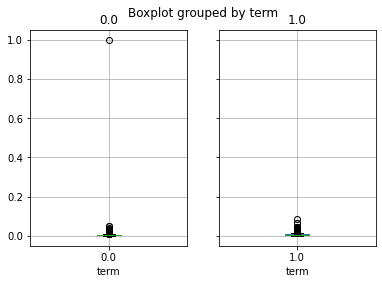

In [39]:
# false pos

acc_false_pos.groupby('term')[['term','dti']].boxplot(by='term', column='annual_inc')

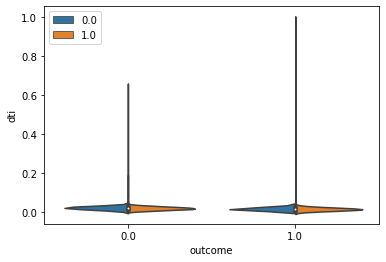

In [40]:
# by outcome

fig, ax = plt.subplots()
ax = sns.violinplot(x='outcome', y='dti', hue='term', data=acc_false, split=True)

ax.legend(loc=2)

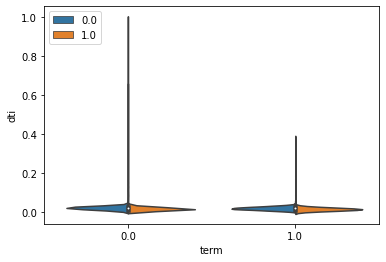

In [41]:
# by term

fig, ax = plt.subplots()
ax = sns.violinplot(x='term', y='dti', hue='outcome', data=acc_false, split=True)

ax.legend(loc=2)

# Support Vector Classification

In [42]:
from sklearn import svm

svm_model = svm.SVC(C=1e2, random_state=state)

In [43]:
%time svm_model.fit(xtrain, ytrain)

Wall time: 2h 40min 8s


SVC(C=100.0, random_state=0)

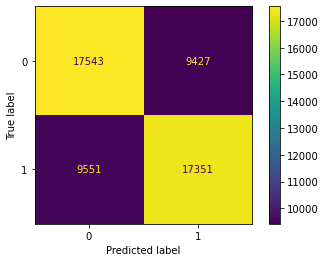

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm_model, xtest, ytest)

In [45]:
svm_model2 = svm.SVC(C=1e-2, random_state=state)

In [46]:
%time svm_model2.fit(xtrain, ytrain)

Wall time: 39min 56s


SVC(C=0.01, random_state=0)

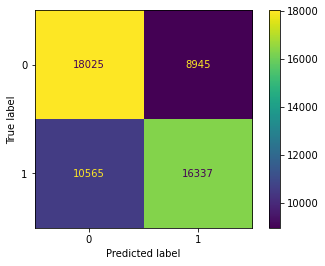

In [47]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm_model2, xtest, ytest)